In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random
from decimal import Decimal

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import matplotlib as mpl

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models_svd
import loss
import metrics
import train_epoch
import val_epoch
import utils

# AIMET imports

In [2]:
from aimet_torch.compress import ModelCompressor
from aimet_torch.defs import ChannelPruningParameters
from aimet_torch.onnx_utils import OnnxSaver
from aimet_common.defs import CostMetric, CompressionScheme, GreedySelectionParameters
# from aimet_common.utils import start_bokeh_server_session
# from aimet_torch.visualize_serialized_data import VisualizeCompression

2024-07-07 11:24:37,144 - root - INFO - AIMET


# Supress Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Empty Cuda

In [4]:
#torch.cuda.empty_cache()

# Define Matplot Style

In [5]:
mpl.style.use('seaborn-v0_8')

# Logger

In [6]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            f'\tChannel Pruning Compression Ratio = {config.PRUNING_COMPRESSION_RATIO}\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

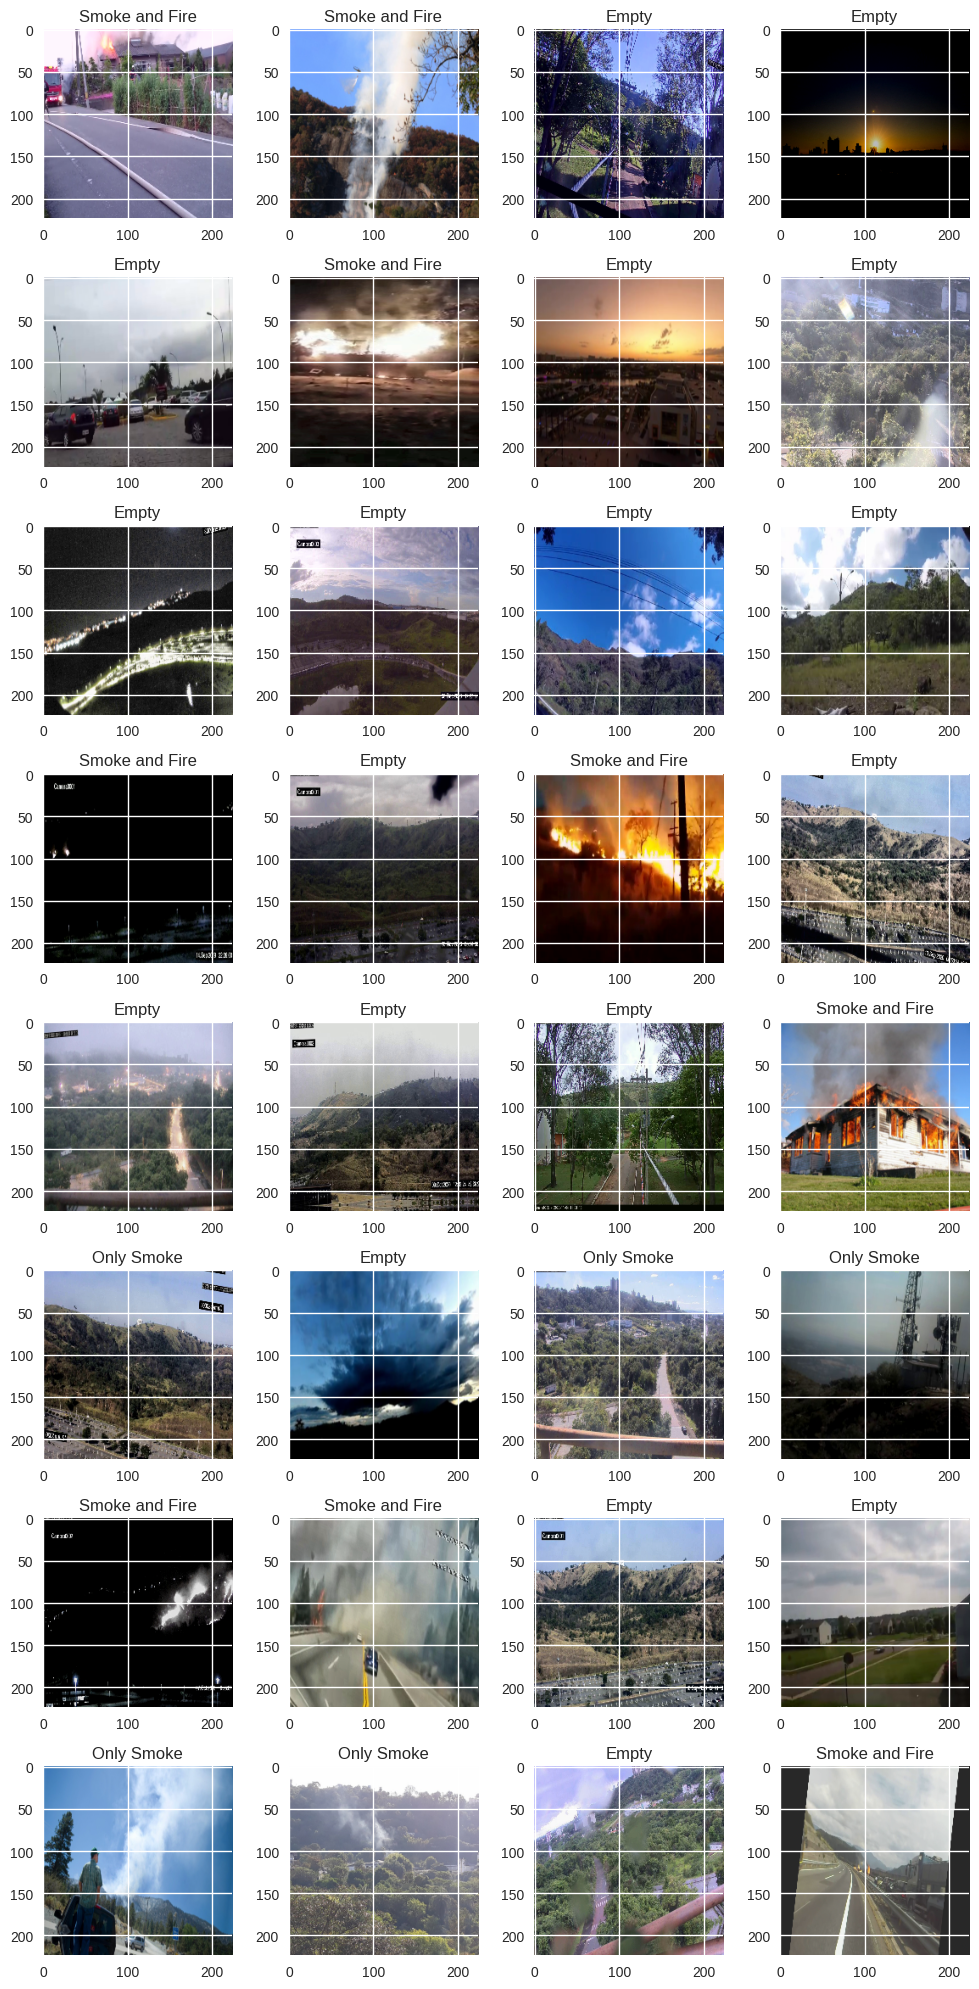

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [10]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset


Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Models Setup

Agressive SVD and Pruning
- Using model with **SVD 0.65**, trained 3 epochs
- BED_classifier__svd_065__epoch=3.pt

Soft SVD and Pruning
- Using model with **SVD 0.80**, trained 26 epochs
- BED_classifier__smoke__precision=0.919__recall=0.9069__epoch=26.pt

In [11]:
if config.MODEL == "BED":   
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    #fp32_model = models_svd.SVD_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)    
    fp32_model = models_svd.SVD_080_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 73922
Total parameters = 73922



### Check Model Shape

In [12]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[ 0.2548, -0.0169],
        [ 0.2670, -0.0021],
        [ 0.2562, -0.0314],
        [ 0.2448, -0.0123]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
SVD_080_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (0): Conv2d(32, 9, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(9, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (relu31): ReLU()
    (conv32): Sequential(
      (0): Conv2d(16, 28, kernel_size=(3, 1), stride=(1, 

# Load Pretrained or Initialize Weights

In [13]:
epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, 
                                       fp32_model, 
                                       optimizer=None, 
                                       scheduler=None, 
                                       device=config.DEVICE)

logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 26 epochs


# Torchinfo: model summary

In [14]:
print(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
SVD_080_BED_CLASSIFIER                   [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        896
│    └─ReLU: 2-2                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 32, 112, 112]        --
│    └─Sequential: 2-5                   [64, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 9, 112, 112]         864
│    │    └─Conv2d: 3-2                  [64, 16, 112, 112]        448
│    └─ReLU: 2-6                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 16, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 16, 56, 56]          272
│    └─ReLU

# Save ONNX original model

In [15]:
input_shape = (1, 3, config.IMG_H, config.IMG_W)

torch.onnx.export(fp32_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'fp32_model_svd.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', fp32_model, input_shape)

# AIMET Channel Pruning

### Start Visualization Server

In [16]:
# visualization_url, process = start_bokeh_server_session()
# print(visualization_url)

### Configure Channel Pruning Parameters

In [17]:
modules_to_ignore = [fp32_model.model.conv1]
#modules_to_ignore = []
greedy_params = GreedySelectionParameters(target_comp_ratio=Decimal(config.PRUNING_COMPRESSION_RATIO),
                                          saved_eval_scores_dict=config.PRUNING_DIC_FILE)
auto_params = ChannelPruningParameters.AutoModeParams(greedy_params,
                                                  modules_to_ignore=modules_to_ignore)
cp_params = ChannelPruningParameters(mode=ChannelPruningParameters.Mode.auto,
                                     params=auto_params,
                                     data_loader=val_loader,
                                     num_reconstruction_samples=500,
                                     allow_custom_downsample_ops=False)

### Evaluate Model Callback

Signature: (model, iterations, use_cuda)
Return an accuracy metric

In [18]:
def evaluate_model(model, iterations, use_cuda):
    
    model.eval()

    for batch_idx, (x, y) in enumerate(val_loader):
        if use_cuda == True:
            x, y = x.to('cuda'), y.to('cuda')
        else:
            model.to('cpu')
        out = model(x)
        if iterations is not None:
            if batch_idx == iterations:
                break
        
        # F1 average Macro   
        yhat = torch.sigmoid(out.detach())
        metrics.f1_metric_mean.update(yhat, y)
    
    f1_mean = metrics.f1_metric_mean.compute()
    metrics.f1_metric_mean.reset()

    print(f'F1 mean: {f1_mean:.4f}')
    
    return f1_mean.item()

### Baseline F1 Mean

In [19]:
baseline_f1 = evaluate_model(fp32_model, None, True)
print(type(baseline_f1))

F1 mean: 0.9207
<class 'float'>


In [20]:
comp_model, stats = ModelCompressor.compress_model(fp32_model,
                                                   input_shape=input_shape,
                                                   eval_callback=evaluate_model,
                                                   eval_iterations=None,
                                                   compress_scheme=CompressionScheme.channel_pruning,
                                                   cost_metric=CostMetric.memory, #.mac,
                                                   parameters=cp_params,
                                                   visualization_url=None)                                                    

2024-07-07 11:26:11,532 - CompRatioSelect - INFO - Greedy selection: Read eval dict from ./data/greedy_selection_eval_scores_dict.pkl
2024-07-07 11:26:11,533 - CompRatioSelect - INFO - Greedy selection: overall_min_score=0.000000, overall_max_score=0.921088
2024-07-07 11:26:11,533 - CompRatioSelect - INFO - Greedy selection: Original model cost=(Cost: memory=73424, mac=170499104)
2024-07-07 11:26:19,405 - CompRatioSelect - INFO - Greedy selection: final choice - comp_ratio=0.883894, score=0.916141
2024-07-07 11:26:20,744 - ChannelPruning - INFO - finished linear regression fit 
2024-07-07 11:26:22,091 - ChannelPruning - INFO - finished linear regression fit 
2024-07-07 11:26:23,430 - ChannelPruning - INFO - finished linear regression fit 
2024-07-07 11:26:24,757 - ChannelPruning - INFO - finished linear regression fit 
2024-07-07 11:26:26,129 - ChannelPruning - INFO - finished linear regression fit 
2024-07-07 11:26:27,475 - ChannelPruning - INFO - finished linear regression fit 
2024-

In [21]:
print(comp_model)
logger.info(comp_model)

SVD_080_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (0): Conv2d(22, 6, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(6, 14, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(14, 8, kernel_size=(1, 1), stride=(1, 1))
    (relu31): ReLU()
    (conv32): Sequential(
      (0): Conv2d(8, 11, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (1): Conv2d(11, 25, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    )
    (relu32): ReLU()
    (conv33): Conv2d(25, 32, kernel_size=(1, 1), stride=(1, 

### Print Stats

In [22]:
print(stats)
logger.info(stats)

**********************************************************************************************
Compressed Model Statistics
Baseline model accuracy: 0.920738, Compressed model accuracy: 0.888464
Compression ratio for memory=0.883894, mac=0.764403

**********************************************************************************************

Per-layer Stats
    Name:model.conv2.0, compression-ratio: 0.7
    Name:model.conv2.1, compression-ratio: 0.7
    Name:model.conv31, compression-ratio: 0.9
    Name:model.conv32.0, compression-ratio: 0.5
    Name:model.conv32.1, compression-ratio: 0.4
    Name:model.conv33, compression-ratio: 0.8
    Name:model.conv34, compression-ratio: None
    Name:model.conv41, compression-ratio: 0.9
    Name:model.conv42, compression-ratio: None
    Name:model.conv43, compression-ratio: None
    Name:model.conv44, compression-ratio: None
    Name:model.conv45, compression-ratio: None
    Name:model.conv46.0, compression-ratio: 0.9
    Name:model.conv46.1, compr

### Torchinfo: model compressed summary

In [23]:
print(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info("Compressed Model Summary")
logger.info(summary(comp_model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
SVD_080_BED_CLASSIFIER                   [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 22, 224, 224]        616
│    └─ReLU: 2-2                         [64, 22, 224, 224]        --
│    └─Dropout2d: 2-3                    [64, 22, 224, 224]        --
│    └─MaxPool2d: 2-4                    [64, 22, 112, 112]        --
│    └─Sequential: 2-5                   [64, 14, 112, 112]        --
│    │    └─Conv2d: 3-1                  [64, 6, 112, 112]         396
│    │    └─Conv2d: 3-2                  [64, 14, 112, 112]        266
│    └─ReLU: 2-6                         [64, 14, 112, 112]        --
│    └─Dropout2d: 2-7                    [64, 14, 112, 112]        --
│    └─MaxPool2d: 2-8                    [64, 14, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 8, 56, 56]           120
│    └─ReLU

### Evaluate Compressed Model

In [24]:
comp_f1 = evaluate_model(comp_model, None, True)

F1 mean: 0.8885


### Visualize Results

In [25]:
comp_ratios_file_path = './data/greedy_selection_comp_ratios_list.pkl'
eval_scores_path = './data/greedy_selection_eval_scores_dict.pkl'

unpickled_ratios = pd.read_pickle(comp_ratios_file_path)
unpickled_scores = pd.read_pickle(eval_scores_path)

In [26]:
df_scores = pd.DataFrame(unpickled_scores)
df_scores.to_csv(config.RUN_FOLDER + 'scores.csv')
print(df_scores)

     model.conv2.0  model.conv2.1  model.conv31  model.conv32.0  \
0.1       0.777983       0.697584      0.587966        0.216630   
0.2       0.777047       0.680184      0.629239        0.571559   
0.3       0.866570       0.843318      0.618500        0.646212   
0.4       0.900897       0.851951      0.868621        0.913237   
0.5       0.914159       0.906105      0.912398        0.916748   
0.6       0.915183       0.910434      0.908596        0.916472   
0.7       0.918072       0.918561      0.915107        0.917814   
0.8       0.920472       0.919391      0.915465        0.918892   
0.9       0.918599       0.920943      0.918203        0.920149   

     model.conv32.1  model.conv33  model.conv34  model.conv41  model.conv42  \
0.1        0.358646      0.493185      0.676375      0.335958      0.203596   
0.2        0.842169      0.669320      0.812263      0.626030      0.115387   
0.3        0.911923      0.782081      0.864515      0.770640      0.460980   
0.4        0.

In [27]:
df_ratios = pd.DataFrame(unpickled_ratios)
df_ratios.to_csv(config.RUN_FOLDER + 'ratios.csv')
print(df_ratios)

                 0     1
0    model.conv2.0   0.7
1    model.conv2.1   0.7
2     model.conv31   0.9
3   model.conv32.0   0.5
4   model.conv32.1   0.4
5     model.conv33   0.8
6     model.conv34  None
7     model.conv41   0.9
8     model.conv42  None
9     model.conv43  None
10    model.conv44  None
11    model.conv45  None
12  model.conv46.0   0.9
13  model.conv46.1   0.5


# Save Compressed Before Training

In [28]:
torch.onnx.export(comp_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_noTrain.onnx')

### Optimizer and Scheduler of Compressed Model to Train

In [29]:
optimizer = optim.Adam(comp_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

utils.save_checkpoint(epoch=0, 
                      model=comp_model,
                      optimizer=optimizer,
                      scheduler=scheduler,
                      checkpoint_name=config.WEIGHTS_FOLDER + 'comp_model_after_pruning.pt')

# Loss Function

In [30]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [31]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [32]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Train Loop Function

In [33]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Training

In [34]:
print("Start Training\n")
logger.info("Start Training\n")

trained_model = train_loop(comp_model)

Start Training


***Start Training: 11:26:43


=== EPOCH 0/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.346      |22.389      |11.957      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.780      |14.806      |6.974       
SMOKE -> Precision: 0.909 - Recall: 0.877 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.916 - Recall: 0.934 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 21.780
Saving model with best Mean F1: 0.9089

=== EPOCH 1/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.408      |20.979      |10.429      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.905      |14.809      |7.096       
SMOKE -> Precision: 0.898 - Recall: 0.892 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.956 - Recall: 0.903 - Accuracy: 0.964 - F1: 0.929
Saving model with best Mean F1: 0.9118

=== EPOCH 2/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.302      |20.398      |9.904       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.607      |14.632      |6.974       
SMOKE -> Precision: 0.901 - Recall: 0.900 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.921 - Recall: 0.929 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 21.607

Saving model with new best smoke precision: 0.901
Saving model with best Mean F1: 0.9124

=== EPOCH 3/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.975      |20.270      |9.705       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.345      |14.530      |6.815       
SMOKE -> Precision: 0.898 - Recall: 0.900 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.946 - Recall: 0.920 - Accuracy: 0.966 - F1: 0.933

Saving model with new best validation loss: 21.345
Saving model with best Mean F1: 0.9161

=== EPOCH 4/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.517      |19.925      |9.591       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.568      |14.716      |6.852       
SMOKE -> Precision: 0.908 - Recall: 0.871 - Accuracy: 0.895 - F1: 0.889
FIRE -> Precision: 0.927 - Recall: 0.929 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 5/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.429      |19.234      |9.196       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.529      |14.215      |7.315       
SMOKE -> Precision: 0.894 - Recall: 0.913 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.889 - Recall: 0.948 - Accuracy: 0.956 - F1: 0.918

=== EPOCH 6/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.780      |19.508      |9.272       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.892      |14.138      |6.754       
SMOKE -> Precision: 0.892 - Recall: 0.912 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.932 - Recall: 0.924 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 20.892

=== EPOCH 7/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.274      |19.130      |9.144       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.885      |14.069      |6.816       
SMOKE -> Precision: 0.913 - Recall: 0.884 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.944 - Recall: 0.918 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 20.885

=== EPOCH 8/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.877      |18.865      |9.012       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.756      |14.955      |6.801       
SMOKE -> Precision: 0.916 - Recall: 0.857 - Accuracy: 0.893 - F1: 0.885
FIRE -> Precision: 0.920 - Recall: 0.934 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 9/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.009      |18.817      |9.193       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.347      |14.511      |6.836       
SMOKE -> Precision: 0.904 - Recall: 0.883 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.919 - Recall: 0.929 - Accuracy: 0.960 - F1: 0.924

=== EPOCH 10/19 ===
Learning Rate = 0.0001



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.760      |18.908      |8.852       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.139      |14.116      |7.023       
SMOKE -> Precision: 0.890 - Recall: 0.915 - Accuracy: 0.904 - F1: 0.902
FIRE -> Precision: 0.902 - Recall: 0.938 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 11/19 ===
Learning Rate = 8e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.804      |18.840      |8.964       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.585      |13.843      |6.742       
SMOKE -> Precision: 0.901 - Recall: 0.904 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.926 - Recall: 0.933 - Accuracy: 0.963 - F1: 0.930

Saving model with new best validation loss: 20.585

Saving model with new best smoke precision: 0.901

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 12/19 ===
Learning Rate = 8e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.493      |18.578      |8.915       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.955      |13.791      |7.164       
SMOKE -> Precision: 0.894 - Recall: 0.907 - Accuracy: 0.904 - F1: 0.901
FIRE -> Precision: 0.896 - Recall: 0.944 - Accuracy: 0.957 - F1: 0.919

=== EPOCH 13/19 ===
Learning Rate = 8e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.886      |18.421      |8.465       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.645      |13.629      |7.016       
SMOKE -> Precision: 0.904 - Recall: 0.902 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.937 - Recall: 0.918 - Accuracy: 0.963 - F1: 0.927

Saving model with new best smoke precision: 0.904

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 14/19 ===
Learning Rate = 8e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.823      |18.242      |8.581       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.802      |14.016      |6.786       
SMOKE -> Precision: 0.897 - Recall: 0.901 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.930 - Recall: 0.931 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 15/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.502      |17.978      |8.523       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.575      |13.850      |6.724       
SMOKE -> Precision: 0.887 - Recall: 0.923 - Accuracy: 0.906 - F1: 0.905
FIRE -> Precision: 0.936 - Recall: 0.925 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 20.575
Saving model with best Mean F1: 0.9177

=== EPOCH 16/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.664      |18.086      |8.578       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.618      |13.721      |6.897       
SMOKE -> Precision: 0.906 - Recall: 0.902 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.916 - Recall: 0.932 - Accuracy: 0.960 - F1: 0.924

Saving model with new best smoke precision: 0.906

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 17/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.620      |18.103      |8.517       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.012      |14.076      |6.936       
SMOKE -> Precision: 0.915 - Recall: 0.882 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.905 - Recall: 0.941 - Accuracy: 0.959 - F1: 0.923

=== EPOCH 18/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.571      |18.075      |8.496       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.434      |13.656      |6.778       
SMOKE -> Precision: 0.905 - Recall: 0.904 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.931 - Recall: 0.926 - Accuracy: 0.963 - F1: 0.929

Saving model with new best validation loss: 20.434

Saving model with precision > 0.9 and recall > 0.9

=== EPOCH 19/19 ===
Learning Rate = 6.400000000000001e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.545      |17.846      |8.700       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.387      |13.675      |6.712       
SMOKE -> Precision: 0.900 - Recall: 0.907 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.931 - Recall: 0.922 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 20.387

***Script finished: 11:35:48

Time elapsed: 0:09:05.233979


# Check Comp Model Params

In [35]:
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in comp_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = sum(p.numel() for p in comp_model.parameters())
print(f'Total parameters = {n_params}')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 65359
Total parameters = 65359


# Export to ONNX

In [36]:
torch.onnx.export(trained_model, torch.randn(input_shape).to(config.DEVICE), config.RUN_FOLDER + 'comp_model_Train.onnx')
#OnnxSaver.set_node_names('/models/fp32_model.onnx', trained_model, input_shape)